In [1]:
!pip install pandas numpy scikit-learn transformers torch xgboost matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, log_loss
from sklearn.feature_selection import mutual_info_classif
from transformers import AutoTokenizer, AutoModel
import torch
import xgboost as xgb#uses decision tree as a base,combines sequential decision trees by calculating error difference and error diff of one tree is fed into other tree and done till stopping criterion is satisfied.
import matplotlib.pyplot as plt
import seaborn as sns

Data cleaning

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('/content/Eclipse.csv',sep=';')
print(df.columns.tolist())
print(df.isnull().sum())


['bugID', 'sd', 'cl', 'pd', 'co', 'rp', 'os', 'bs', 'rs', 'pr', 'bsr']
bugID       0
sd          0
cl          0
pd          0
co          0
rp          0
os          0
bs          0
rs       1115
pr          0
bsr         0
dtype: int64


In [4]:
print(df.describe(include=object))

                                                       sd               cl  \
count                                                8478             8478   
unique                                               8336               15   
top     Fix files that have ended up with CRLF in the ...  Eclipse Project   
freq                                                    6             2538   

             pd    co    rp          os        bs     rs    pr     bsr  
count      8478  8478  8478        8478      8478   7363  8478    8478  
unique      135   329     5          15         7      7     5       7  
top     Capella  Core    PC  Windows 10  RESOLVED  FIXED    P3  normal  
freq       1678  1176  5999        2656      3813   5905  8042    5560  


In [5]:
df=df.dropna(subset=['rs','bsr']).reset_index(drop=True)
print(df.isnull().sum())


bugID    0
sd       0
cl       0
pd       0
co       0
rp       0
os       0
bs       0
rs       0
pr       0
bsr      0
dtype: int64


In [6]:
print(df['rs'].head(10))

0         FIXED
1     DUPLICATE
2         FIXED
3     DUPLICATE
4    WORKSFORME
5    WORKSFORME
6         FIXED
7         FIXED
8         FIXED
9         FIXED
Name: rs, dtype: object


In [7]:
df['defective']=df['rs'].apply(lambda x:1 if x.upper() in ['FIXED'] else 0)
print(df.columns)
print(df.head(5))
print(df['defective'].value_counts(normalize=True))


Index(['bugID', 'sd', 'cl', 'pd', 'co', 'rp', 'os', 'bs', 'rs', 'pr', 'bsr',
       'defective'],
      dtype='object')
    bugID                                                 sd  \
0  550000            PDE quickfix creates invalid @Since tag   
1  550001  Grant access to projects storage service to th...   
2  550002               Add relation information to REST-API   
3  550003  Provide platform independent plug-in to set th...   
4  550004  Inline method refacting reports "Inaccurate re...   

                   cl         pd          co   rp     os        bs  \
0     Eclipse Project        PDE   API Tools   PC  Linux  VERIFIED   
1  Eclipse Foundation  Community  CI-Jenkins   PC  Linux    CLOSED   
2          Automotive      MDMBL     General  All    All    CLOSED   
3     Eclipse Project   Platform          UI   PC  Linux    CLOSED   
4     Eclipse Project        JDT          UI   PC  Linux  RESOLVED   

           rs  pr     bsr  defective  
0       FIXED  P3  normal          

In [8]:
#Drop duplicates
df=df.drop_duplicates()


Exploratory Data Analysis

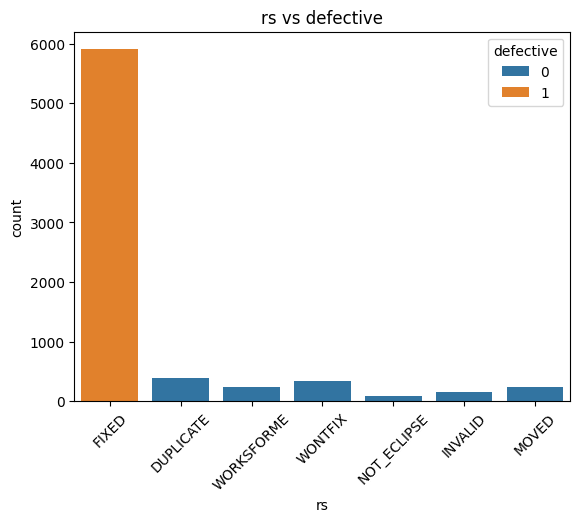

In [9]:
sns.countplot(x=df['rs'],hue=df['defective'])
plt.xticks(rotation=45)
plt.title('rs vs defective')
plt.show()

rs
FIXED          1.0
DUPLICATE      0.0
INVALID        0.0
MOVED          0.0
NOT_ECLIPSE    0.0
WONTFIX        0.0
WORKSFORME     0.0
Name: defective, dtype: float64


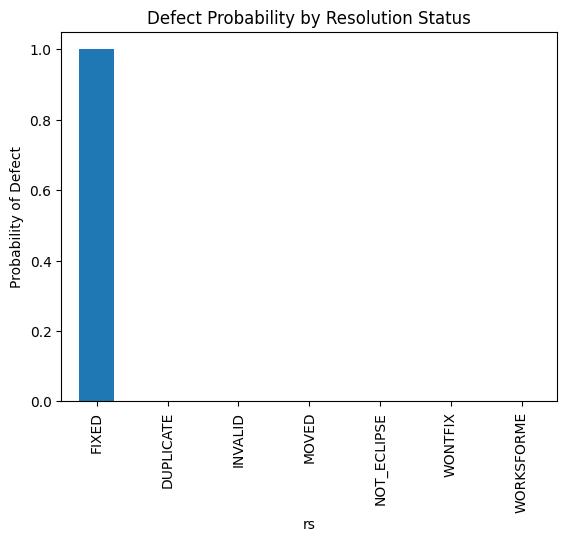

In [10]:
defect_rate = df.groupby('rs')['defective'].mean().sort_values(ascending=False)
print(defect_rate)
defect_rate.plot(kind='bar')
plt.ylabel("Probability of Defect")
plt.title("Defect Probability by Resolution Status")
plt.show()


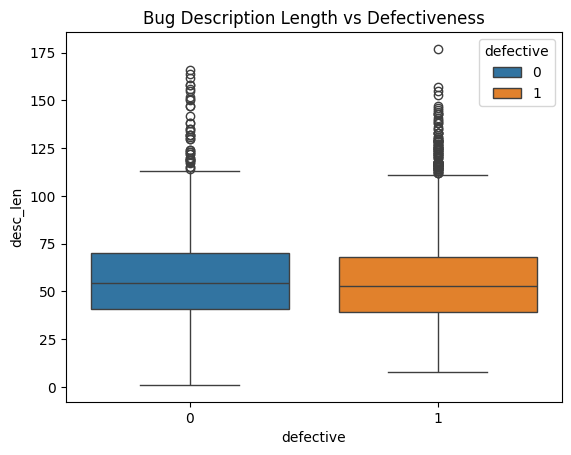

In [11]:
df['desc_len'] = df['sd'].str.len()
sns.boxplot(x='defective', y='desc_len',hue='defective', data=df)
plt.title("Bug Description Length vs Defectiveness")
plt.show()


Exploratory Data Analysis (EDA) Summary
1. Resolution Status vs Defectiveness

The analysis of resolution status (rs) reveals a very strong association with defectiveness. Bug reports resolved as FIXED consistently correspond to defective instances, while other resolution categories such as DUPLICATE, INVALID, WORKSFORME, WONTFIX, MOVED, and NOT_ECLIPSE are almost exclusively non-defective. This pattern is clearly visible in both the count distribution and the computed defect probabilities, where the probability of defect for FIXED cases approaches 1.0, and remains near zero for all other categories.

This observation aligns well with real-world bug triaging practices, where FIXED typically indicates a confirmed software defect, whereas other resolutions often reflect invalid, redundant, or non-actionable reports. However, since resolution status is assigned after bug investigation, it represents post-hoc information and may introduce label leakage if used directly as a predictive feature. Therefore, this attribute is primarily used for exploratory validation and interpretability rather than as a direct input to the predictive model.

2. Class Distribution Across Resolution Categories

The count plot further highlights a highly imbalanced distribution across resolution types. The FIXED category dominates the defective class, while non-defective cases are distributed across multiple alternative resolutions. This imbalance reinforces the need for careful modeling strategies and supports the choice of text-driven learning approaches over simple rule-based or metadata-only classification.

3. Bug Description Length vs Defectiveness

The relationship between bug description length and defectiveness was examined using box plots. The distributions of description length for defective and non-defective bugs show substantial overlap, with comparable median values across both classes. While defective bugs exhibit slightly higher variability and a heavier upper tail, the overall similarity in central tendency indicates that description length alone is not a strong discriminative feature.

This result suggests that superficial textual characteristics, such as length, are insufficient to distinguish defective from non-defective reports. Instead, the semantic content of the bug descriptions plays a more critical role, justifying the use of contextual language models to capture deeper intent and meaning.

4. Key Insights from EDA

Resolution status is highly correlated with defectiveness, validating label consistency but also indicating potential label leakage.

Defectiveness cannot be reliably inferred from simple surface-level features such as description length.

The strong overlap in textual length distributions emphasizes the need for semantic modeling rather than heuristic-based features.

These findings collectively motivate the adoption of language model embeddings and explainable learning frameworks for robust defect prediction.

5. Implications for Model Design

The EDA results support the design choice of leveraging contextual textual representations for defect prediction, while using metadata attributes primarily for analytical validation and explainability. By focusing on semantic embeddings, the proposed approach aims to capture meaningful defect-related intent without relying on post-resolution signals.

Ranking logic for all feature selection methods

In [12]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.ensemble import RandomForestClassifier

# ---------------- Modified Ranking Logic ----------------
def aggregate_feature_scores(score_series, top_n_features=30, final_n_columns=5, default_col='sd'):
    # Take top N features by score
    top = score_series.head(top_n_features).reset_index()
    top.columns = ['encoded_feature', 'score']
    top['original_col'] = top['encoded_feature'].str.split('_').str[0]

    # Aggregate: max score + frequency
    agg = top.groupby('original_col').agg(
        max_score=('score', 'max'),
        frequency=('score', 'count')
    ).reset_index()

    # Sort primarily by score, secondarily by frequency
    agg = agg.sort_values(by=['max_score', 'frequency'], ascending=[False, False])

    # Always include default_col first, even if not in top N
    best_columns = [default_col]

    # Add next best features excluding default_col
    additional_cols = agg[agg['original_col'] != default_col].head(final_n_columns - 1)['original_col'].tolist()
    best_columns += additional_cols

    return best_columns, agg

features = [col for col in df.columns if col not in ['bugID', 'defective']]
X = df[features]
y = df['defective']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X.astype(str))

# ---------------- Mutual Information ----------------
mi_scores = pd.Series(mutual_info_classif(X_encoded, y, discrete_features=True),
                      index=X_encoded.columns).sort_values(ascending=False)

mi_best, mi_agg = aggregate_feature_scores(mi_scores, top_n_features=30, final_n_columns=5, default_col='sd')
print("\n[Mutual Information] Best columns:", mi_best)
print(mi_agg)

# ---------------- Chi-Square ----------------
chi_scores, _ = chi2(X_encoded, y)
chi_series = pd.Series(chi_scores, index=X_encoded.columns).sort_values(ascending=False)

chi_best, chi_agg = aggregate_feature_scores(chi_series, top_n_features=30, final_n_columns=5, default_col='sd')
print("\n[Chi-Square] Best columns:", chi_best)
print(chi_agg)

# ---------------- Cramér’s V ----------------
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2_val = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2_val / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

correlations = {col: cramers_v(X[col], y) for col in X.columns}
correlation_series = pd.Series(correlations).sort_values(ascending=False)

cram_best, cram_agg = aggregate_feature_scores(correlation_series, top_n_features=30, final_n_columns=5, default_col='sd')
print("\n[Cramér’s V] Best columns:", cram_best)
print(cram_agg)

# ---------------- Random Forest Feature Importance ----------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_encoded, y)

rf_scores = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False)
rf_best, rf_agg = aggregate_feature_scores(rf_scores, top_n_features=30, final_n_columns=5, default_col='sd')

print("\n[Random Forest] Best columns:", rf_best)
print(rf_agg)



[Mutual Information] Best columns: ['sd', 'rs', 'bs', 'cl', 'pd']
  original_col  max_score  frequency
7           rs   0.497679          7
0           bs   0.080721          3
1           cl   0.016747          4
4           pd   0.011097          6
2           co   0.008760          4
3           os   0.007700          1
6           rp   0.007197          3
5           pr   0.005301          2

[Chi-Square] Best columns: ['sd', 'rs', 'bs', 'cl', 'co']
  original_col    max_score  frequency
8           rs  1599.506173          7
0           bs   863.494325          3
2           cl   189.995296          3
3           co   168.371511          7
5           pd   150.718683          5
4           os    72.343293          1
7           rp    70.248541          2
6           pr    43.117043          1
1          bsr    37.438915          1

[Cramér’s V] Best columns: ['sd', 'rs', 'bs', 'co', 'pd']
   original_col  max_score  frequency
9            rs   0.999660          1
0            bs 

Intent creation

In [13]:


# ---------------- Create intent_text ----------------
final_cols = mi_best  # or anova_best / chi_best / cram_best
df['intent_text'] = df[final_cols].astype(str).agg(" ".join, axis=1)
print("\nSample intent_text with selected features:\n", df[['intent_text','defective']].head(10))



Sample intent_text with selected features:
                                          intent_text  defective
0  PDE quickfix creates invalid @Since tag FIXED ...          1
1  Grant access to projects storage service to th...          0
2  Add relation information to REST-API FIXED CLO...          1
3  Provide platform independent plug-in to set th...          0
4  Inline method refacting reports "Inaccurate re...          0
5  Call Hierarchy incorrectly includes binary art...          0
6  UI freezes in PluginsView FIXED VERIFIED Eclip...          1
7  UI freeze in org.eclipse.ui.dialogs.FilteredTr...          1
8  CPD dialog should have a consistent usage of s...          1
9  OpenJ9: Git failing on master, builds blocked ...          1


In [14]:
print(df['intent_text'].duplicated().sum())
df=df.drop_duplicates(subset=['intent_text'])
print(df['intent_text'].nunique())

55
7307


**RoberTa llm**

In [15]:
X=df['intent_text']
y=df['defective']

In [16]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from tqdm import tqdm  # for progress bar (optional)

def get_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=256).to(device)

        with torch.no_grad():
            outputs = model(**tokens)
            # CLS token embedding
            cls_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
            embeddings.extend(cls_embeddings)

    return np.array(embeddings)

# Generate embeddings (now correctly moving to CPU before NumPy)
X_embeddings = get_embeddings(X.tolist(), tokenizer, model, batch_size=32)


100%|██████████| 229/229 [00:16<00:00, 14.25it/s]


In [18]:
print(X_embeddings.shape)

(7307, 768)


In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

# Compute class imbalance ratio
ratio = (y_train.value_counts()[0] / y_train.value_counts()[1])
print("Imbalance ratio:", ratio)


Imbalance ratio: 0.24893162393162394


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:32:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
               precision    recall  f1-score   support

           0    0.97518   0.94178   0.95819       292
           1    0.98559   0.99402   0.98979      1170

    accuracy                        0.98358      1462
   macro avg    0.98039   0.96790   0.97399      1462
weighted avg    0.98351   0.98358   0.98348      1462

Accuracy: 0.98358
Error Rate: 0.01642
ROC-AUC: 0.99869
Cross-Entropy Loss: 0.04074
Balanced Accuracy: 0.96790
Matthews Corrcoef: 0.94820
Brier Score Loss: 0.01150


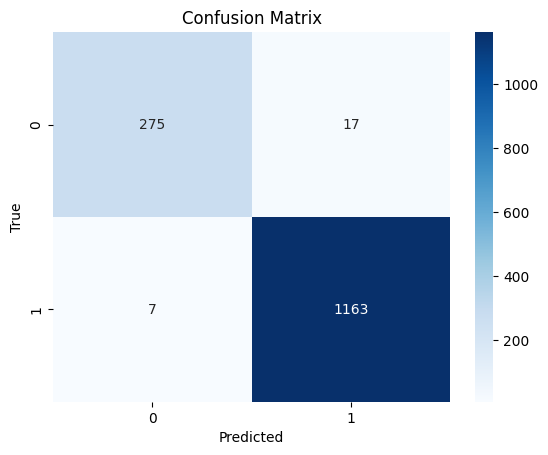

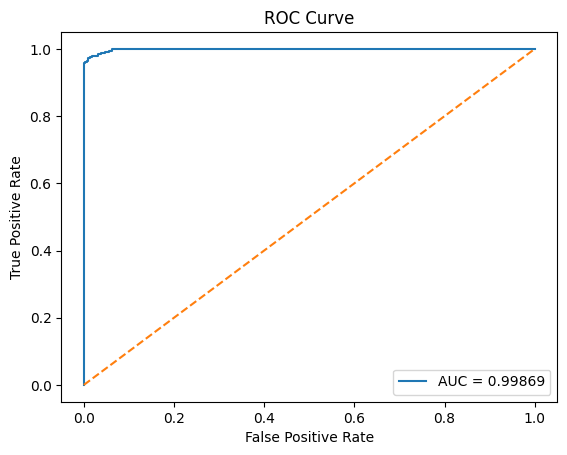

In [20]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    log_loss, roc_curve, precision_score, recall_score,
    f1_score, balanced_accuracy_score, matthews_corrcoef,
    brier_score_loss, accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# ---------------- Regularization in Classifier ----------------
clf = XGBClassifier(
    scale_pos_weight=ratio,   # imbalance handling
    max_depth=6,              # limit tree depth
    subsample=0.8,            # random row sampling
    colsample_bytree=0.8,     # random feature sampling
    n_estimators=200,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric="logloss"     # default metric in XGBoost
)

clf.fit(X_train, y_train)

# ---------------- Predictions ----------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=5))

# Accuracy (with full precision)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.5f}")

# Error Rate (1 - Accuracy, also reported by XGBoost internally if eval_metric='error')
error_rate = 1 - acc
print(f"Error Rate: {error_rate:.5f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {roc_auc:.5f}")

# Cross-Entropy Loss (Logloss)
ce_loss = log_loss(y_test, y_prob)
print(f"Cross-Entropy Loss: {ce_loss:.5f}")

# Additional Error Metrics
balanced_acc = balanced_accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
brier = brier_score_loss(y_test, y_prob)

print(f"Balanced Accuracy: {balanced_acc:.5f}")
print(f"Matthews Corrcoef: {mcc:.5f}")
print(f"Brier Score Loss: {brier:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.5f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


SHAP

In [21]:
import shap
shap.initjs()

In [22]:
exp=shap.TreeExplainer(clf)
val=exp(X_test)
import numpy as np
np.shape(val.values)

(1462, 768)

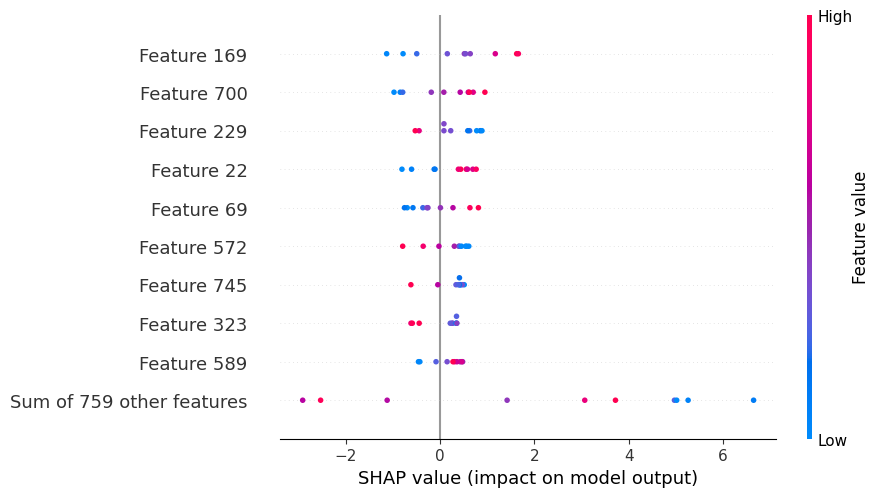

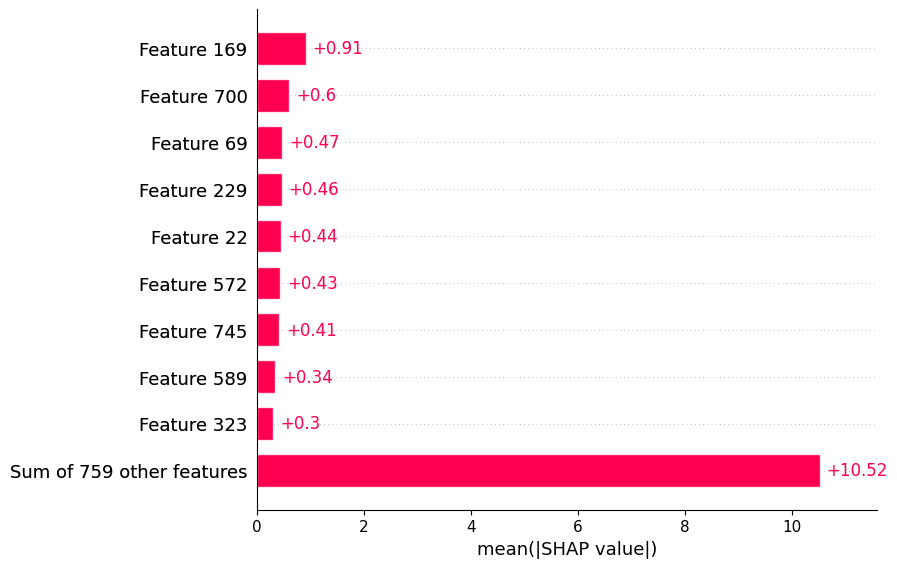

In [23]:
#for global feature contribution
shap.plots.beeswarm(val[0:10])
shap.plots.bar(val)

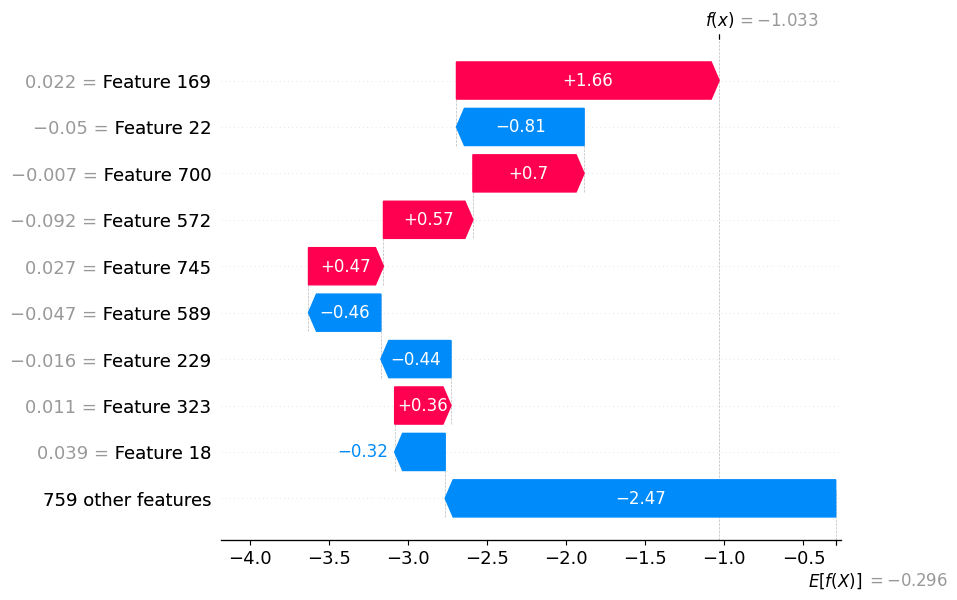

In [24]:
#For single observation
shap.plots.waterfall(val[0])

Checking overfitting

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:33:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:33:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:33:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:33:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:33:06] WARNING: /w

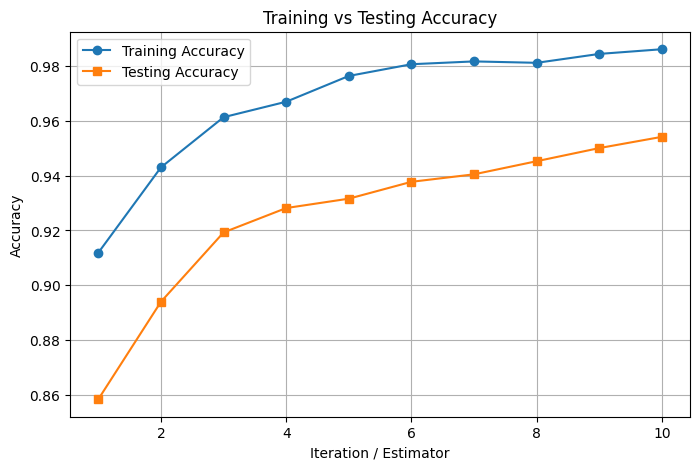

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Suppose you have a list of training and testing predictions at each stage
# Example: if using XGBoost with eval_set, you can get staged predictions

# For demonstration, we'll compute accuracy on training and testing sets
train_acc = []
test_acc = []

# Simulate iterative training (replace this with your actual training loop)
# For example, if using XGBClassifier:
for i in range(1, 11):  # pretend 10 iterations/estimators
    clf.n_estimators = i
    clf.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = clf.predict(X_train)
    train_acc.append(accuracy_score(y_train, y_train_pred))

    # Testing accuracy
    y_test_pred = clf.predict(X_test)
    test_acc.append(accuracy_score(y_test, y_test_pred))

# -----------------------------
# Plot training vs testing curve
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_acc)+1), train_acc, label="Training Accuracy", marker='o')
plt.plot(range(1, len(test_acc)+1), test_acc, label="Testing Accuracy", marker='s')
plt.xlabel("Iteration / Estimator")
plt.ylabel("Accuracy")
plt.title("Training vs Testing Accuracy")
plt.legend()
plt.grid(True)
plt.show()
